In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Mounted at /content/drive
/content/drive/MyDrive/Earthquake Shelter Project


In [2]:
import pickle
import tempfile
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, classification_report, recall_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

from scipy.sparse import csr_matrix

import tensorflow as tf

In [3]:
from joblib import dump, load

In [4]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00


In [5]:
from boruta import BorutaPy
import xgboost as xgb

In [6]:
mpl.rcParams['figure.figsize'] = (16, 9)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
seed = 42

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def read_pickle(dataset_name):
    with open('data/' + dataset_name + '.pkl', 'rb') as file_:
        return pickle.load(file_)

In [9]:
X = np.load('data/arrays/tokyo_more/x.npy', allow_pickle=True).astype(np.float32)
y = np.load('data/arrays/tokyo_more/y.npy', allow_pickle=True).astype(np.float32)

In [10]:
X.shape, y.shape

((8343, 26), (8343, 1))

In [11]:
# This causes all models to only predict either 0s or 1s.
# y = 1 - y

In [12]:
np.sum(y == 1)

286

For Tokyo
- `more` contains 286 out of 8343 (3.43%)
- `less` contains 35 out of 964 (3.63%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6674, 26) (1669, 26) (6674, 1) (1669, 1)


In [25]:
def generate_confusion_matrix(model, X_test, y_test, title='Confusion Matrix'):
    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [13]:
np.float = np.float32
np.int = np.int32
np.bool = np.bool_

# Dataset Visualization

In [ ]:
data = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
data['Label'] = y

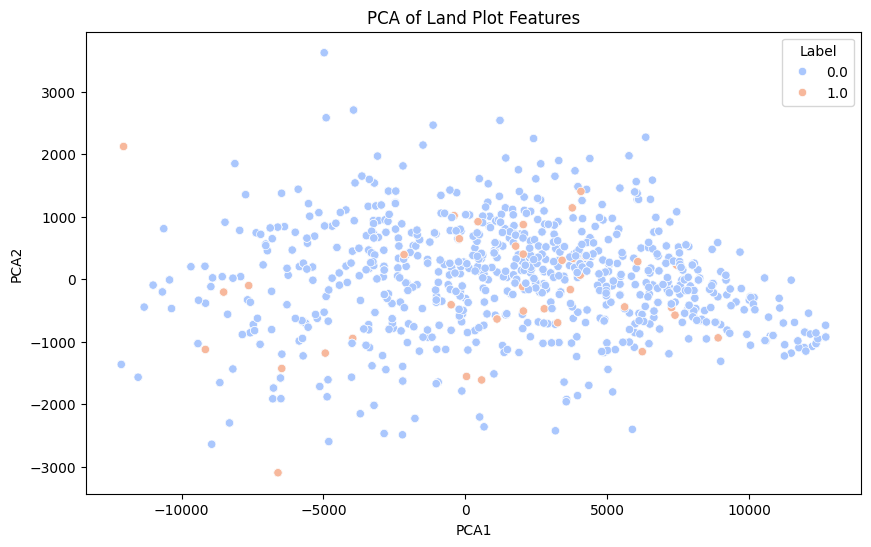

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=data, palette='coolwarm')
plt.title('PCA of Land Plot Features')
plt.show()

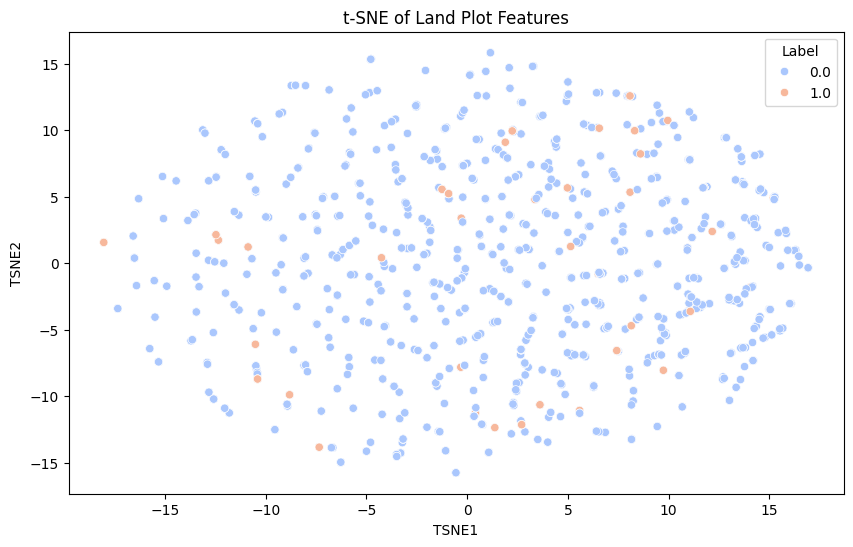

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(X)
data['TSNE1'] = tsne_result[:, 0]
data['TSNE2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=data, palette='coolwarm')
plt.title('t-SNE of Land Plot Features')
plt.show()

# Controls

### Simple Dense NN

In [ ]:
tf.random.set_seed(0)

model1_control = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1_control.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5)])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model1_control_history = model1_control.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
209/209 [==============================] - 6s 5ms/step - loss: 48.7014 - accuracy: 0.9249 - f1_score: 0.0309
Epoch 2/50
209/209 [==============================] - 1s 4ms/step - loss: 0.2976 - accuracy: 0.9564 - f1_score: 0.0000e+00
Epoch 3/50
209/209 [==============================] - 1s 4ms/step - loss: 0.2035 - accuracy: 0.9628 - f1_score: 0.0080
Epoch 4/50
209/209 [==============================] - 1s 4ms/step - loss: 0.1783 - accuracy: 0.9639 - f1_score: 0.0082
Epoch 5/50
209/209 [==============================] - 1s 4ms/step - loss: 0.1709 - accuracy: 0.9637 - f1_score: 0.0000e+00
Epoch 6/50
209/209 [==============================] - 1s 4ms/step - loss: 0.1627 - accuracy: 0.9639 - f1_score: 0.0000e+00
Epoch 7/50
209/209 [==============================] - 1s 4ms/step - loss: 0.1580 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 8/50
209/209 [==============================] - 1s 4ms/step - loss: 0.1559 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 9/50
209/209 [=======

In [ ]:
model1_control.evaluate(X_test, y_test)

53/53 [==============================] - 0s 3ms/step - loss: 0.1281 - accuracy: 0.9718 - f1_score: 0.0000e+00


[0.12805727124214172, 0.971839427947998, array([0.], dtype=float32)]

53/53 [==============================] - 0s 2ms/step


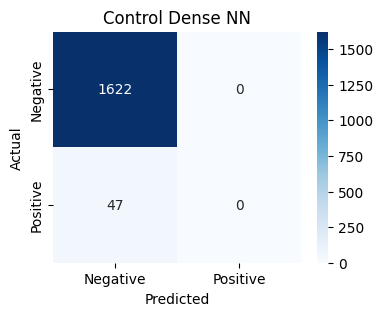

In [ ]:
generate_confusion_matrix(model1_control, X_test, y_test, title='Control Dense NN')

### RandomForest

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, random_state=seed)
model2_history = model2.fit(X_train, y_train.ravel())

model2_y_pred = model2.predict(X_test)

In [ ]:
model2_accuracy = accuracy_score(y_test.ravel(), model2_y_pred)
model2_f1_score = f1_score(y_test.ravel(), model2_y_pred)
print('accuracy:', model2_accuracy, '- f1 score:', model2_f1_score)

accuracy: 0.9706411024565608 - f1 score: 0.0392156862745098


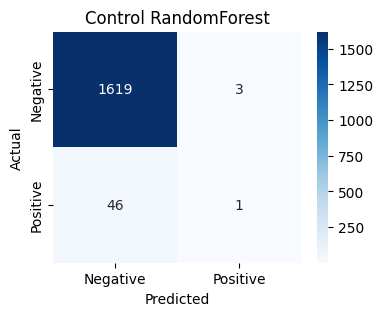

In [ ]:
generate_confusion_matrix(model2, X_test, y_test, title='Control RandomForest')

### XGBoost

In [ ]:
model3 = xgb.XGBClassifier()
model3_history = model3.fit(X_train, y_train.ravel())

model3_y_pred = model3.predict(X_test)

In [ ]:
model3_accuracy = accuracy_score(y_test.ravel(), model3_y_pred)
model3_f1_score = f1_score(y_test.ravel(), model3_y_pred)
print('accuracy:', model3_accuracy, '- f1 score:', model3_f1_score)

accuracy: 0.9712402636309168 - f1 score: 0.04


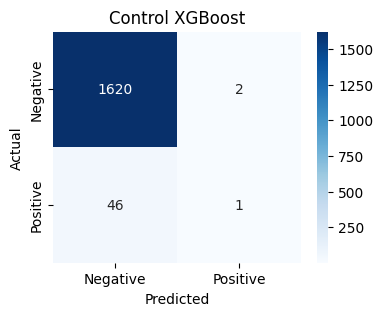

In [ ]:
generate_confusion_matrix(model3, X_test, y_test, title='Control XGBoost')

# Custom Metric

### Dense NN

In [ ]:
def weighted_binary_crossentropy():
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        counts = tf.math.bincount(tf.cast(y_true, tf.int32), minlength=2)
        total = tf.reduce_sum(counts)
        weight_for_0 = tf.cast(counts[1], tf.float32) / tf.cast(total, tf.float32)
        weight_for_1 = tf.cast(counts[0], tf.float32) / tf.cast(total, tf.float32)

        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        bce = y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred)

        weight_vector = y_true * weight_for_1 + (1 - y_true) * weight_for_0
        weighted_bce = - weight_vector * bce

        return tf.reduce_mean(weighted_bce)

    return loss

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model1.compile(loss=weighted_binary_crossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5)])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model1_history = model1.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
209/209 [==============================] - 5s 4ms/step - loss: 0.5408 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 2/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5401 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 3/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5387 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 4/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5418 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 5/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5407 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 6/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5386 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 7/50
209/209 [==============================] - 1s 4ms/step - loss: 0.5414 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 8/50
209/209 [==============================] - 1s 6ms/step - loss: 0.5362 - accuracy: 0.9642 - f1_score: 0.0000e+00
Epoch 9/50
209/2

53/53 [==============================] - 0s 2ms/step


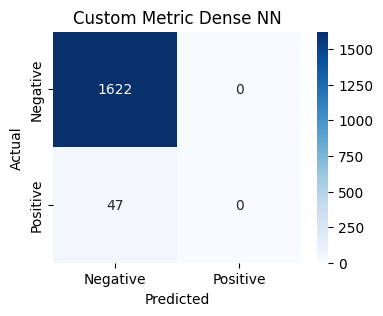

In [ ]:
generate_confusion_matrix(model1, X_test, y_test, title='Custom Metric Dense NN')

### RandomForest

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.ravel()), y=y_train.ravel())
class_weight_dict = {0: 1, 1: 2}

In [ ]:
model22 = RandomForestClassifier(class_weight=class_weight_dict, n_estimators=100, random_state=seed)
model22_history = model22.fit(X_train, y_train.ravel())

model22_y_pred = model22.predict(X_test)

In [ ]:
model22_accuracy = accuracy_score(y_test.ravel(), model22_y_pred)
model22_f1_score = f1_score(y_test.ravel(), model22_y_pred)
print('accuracy:', model22_accuracy, '- f1 score:', model22_f1_score)

accuracy: 0.969442780107849 - f1 score: 0.07272727272727272


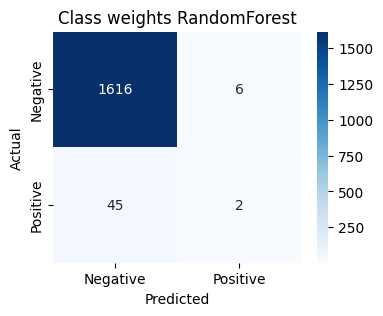

In [ ]:
generate_confusion_matrix(model22, X_test, y_test, title='Class weights RandomForest')

### `imblearn`'s BalancedRandomForestClassifier

In [ ]:
model33 = BalancedRandomForestClassifier(random_state=seed)
model33_history = model33.fit(X_train, y_train.ravel())

In [ ]:
model33_y_pred = model33.predict(X_test)
model33_accuracy = accuracy_score(y_test.ravel(), model33_y_pred)
model33_f1_score = f1_score(y_test.ravel(), model33_y_pred)
print('accuracy:', model33_accuracy, '- f1 score:', model33_f1_score)

accuracy: 0.6572798082684242 - f1 score: 0.09493670886075949


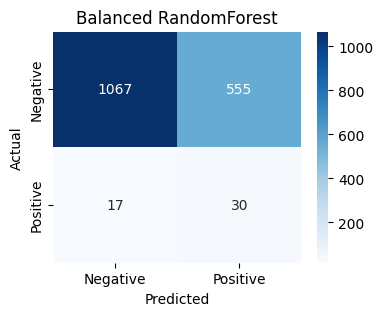

In [ ]:
generate_confusion_matrix(model33, X_test, y_test, title='Balanced RandomForest')

# Boruta Feature Selection

In [ ]:
X_float64 = X.astype(np.float64)  # Convert features to float64
y_int64 = y.astype(np.int64)    # Convert labels to int64

In [ ]:
np.float = np.float32
np.int = np.int32
np.bool = np.bool_

In [ ]:
# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=seed)
brf = RandomForestClassifier(n_estimators=100, random_state=seed)

boruta_selector = BorutaPy(brf, n_estimators='auto', random_state=seed)

boruta_selector.fit(X, y)

BorutaPy(estimator=RandomForestClassifier(n_estimators=72,
                                          random_state=RandomState(MT19937) at 0x7B4BF0BD7440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B4BF0BD7440)

In [ ]:
selected_features = boruta_selector.support_
print("Selected features:", selected_features)

ranking = boruta_selector.ranking_
print("Feature ranking:", ranking)

Selected features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
Feature ranking: [15 19 17 20 21 26 16 18 13 11 23  6 10 12  8 13 26 22 23 26  9  2  3  4
  6  5]


In [ ]:
X_cols = ['stories_above_ground',
 'stories_below_ground',
 'steel_frame',
 'reinforced_concrete',
 'lightweight',
 'block',
 'wood',
 'rice_paddy',
 'other_agriculture',
 'forest',
 'wasteland',
 'building',
 'road_transport',
 'rail_transport',
 'other_site',
 'river_wetland',
 'seashore',
 'sea',
 'golf_course',
 'unknown',
 'dist_to_water',
 '0-14',
 '15-64',
 '65+',
 '75+',
 '80+']

In [ ]:
print("\n------Support and Ranking for each feature------")
for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test:\t", X_cols[i], ' ' * (20 - len(X_cols[i])),
              "\t- Ranking: ", boruta_selector.ranking_[i])
    else:
        print("Doesn't pass the test:\t",
              X_cols[i], ' ' * (20 - len(X_cols[i])), "\t- Ranking: ", boruta_selector.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:	 stories_above_ground  	- Ranking:  15
Doesn't pass the test:	 stories_below_ground  	- Ranking:  19
Doesn't pass the test:	 steel_frame           	- Ranking:  17
Doesn't pass the test:	 reinforced_concrete   	- Ranking:  20
Doesn't pass the test:	 lightweight           	- Ranking:  21
Doesn't pass the test:	 block                 	- Ranking:  26
Doesn't pass the test:	 wood                  	- Ranking:  16
Doesn't pass the test:	 rice_paddy            	- Ranking:  18
Doesn't pass the test:	 other_agriculture     	- Ranking:  13
Doesn't pass the test:	 forest                	- Ranking:  11
Doesn't pass the test:	 wasteland             	- Ranking:  23
Doesn't pass the test:	 building              	- Ranking:  6
Doesn't pass the test:	 road_transport        	- Ranking:  10
Doesn't pass the test:	 rail_transport        	- Ranking:  12
Doesn't pass the test:	 other_site            	- Ranking:  8
Doesn't pass the test:

# Tensorflow's method
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y) #  random_state=seed,
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp) #  random_state=seed,
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(6674, 26) (6674,) (1335, 26) (1335,) (334, 26) (334,)


In [ ]:
neg, pos = np.bincount(y.ravel().astype(np.int64))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 8343
    Positive: 286 (3.43% of total)



In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128 # Use a large batch size because each batch should contain a few positive samples

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', restore_best_weights=True)

In [ ]:
model_tf = make_model()
model_tf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                432       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_tf.predict(X_train[:10])

1/1 [==============================] - 0s 45ms/step


array([[0.0829803 ],
       [0.08447527],
       [0.11634045],
       [0.21782735],
       [0.15305537],
       [0.11765477],
       [0.09830408],
       [0.00970426],
       [0.10135783],
       [0.02900907]], dtype=float32)

Setting output layer to affect bias: https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

In [ ]:
results = model_tf.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2018


In [ ]:
initial_bias = np.log([pos / neg])
initial_bias

array([-3.33830475])

In [ ]:
model_tf_biased = make_model(output_bias=initial_bias)
model_tf_biased.predict(X_train[:10])

1/1 [==============================] - 0s 63ms/step


array([[0.0276974 ],
       [0.08864913],
       [0.10974843],
       [0.01449317],
       [0.05795658],
       [0.04908485],
       [0.00849585],
       [0.9823392 ],
       [0.01829774],
       [0.02064615]], dtype=float32)

In [ ]:
results = model_tf_biased.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2282


This is a 12.12x reduction in loss

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model_tf_biased.save_weights(initial_weights)

In [ ]:
model41 = make_model()
model41.load_weights(initial_weights)
model41.layers[-1].bias.assign([0.0])
zero_bias_history = model41.fit(X_train,
                                y_train,
                                batch_size=BATCH_SIZE,
                                epochs=20,
                                validation_data=(X_val, y_val),
                                verbose=0)

In [ ]:
model42 = make_model()
model42.load_weights(initial_weights)
careful_bias_history = model42.fit(X_train,
                                   y_train,
                                   batch_size=BATCH_SIZE,
                                   epochs=20,
                                   validation_data=(X_val, y_val),
                                   verbose=0)

In [ ]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                color=colors[n], label='Val ' + label,
                linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

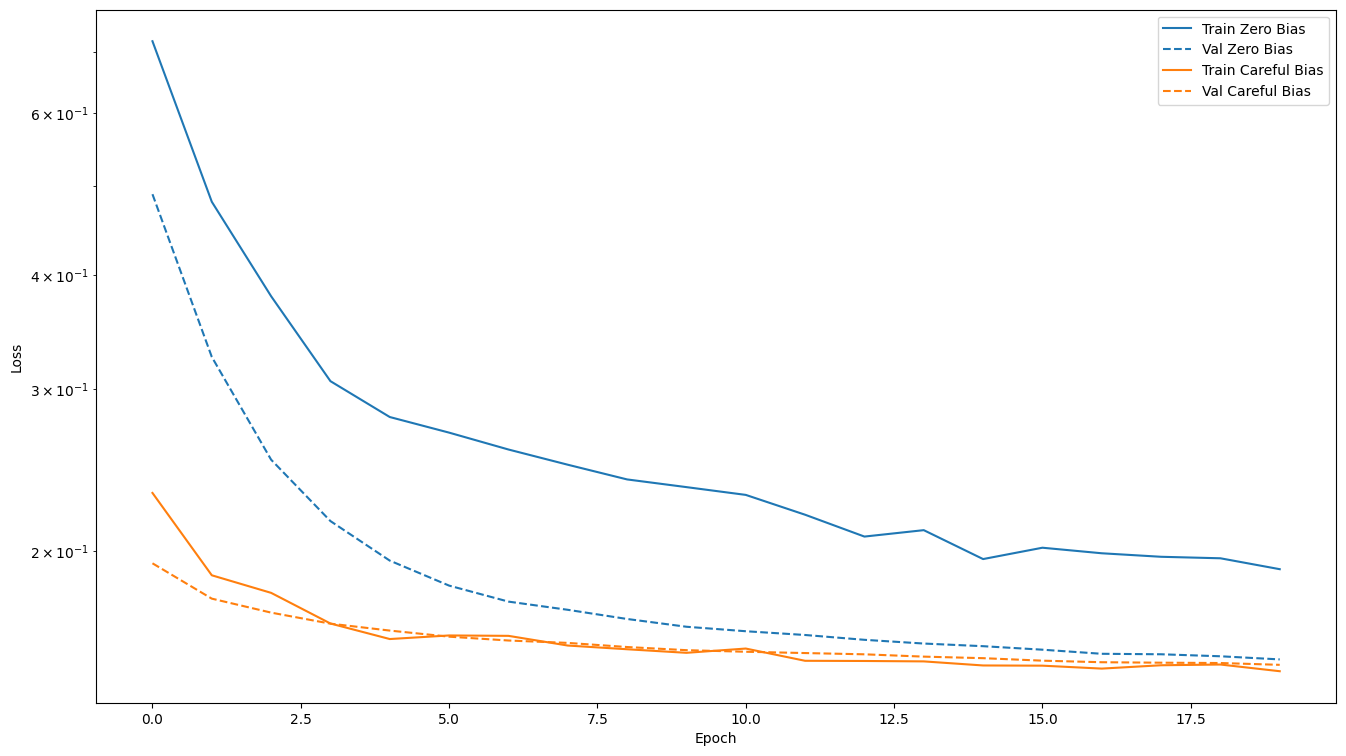

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model44 = make_model()
model44.load_weights(initial_weights)
baseline_history = model44.fit(X_train,
                             y_train,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(X_val, y_val))

Epoch 1/100
53/53 [==============================] - 3s 20ms/step - loss: 0.2312 - cross entropy: 0.2177 - Brier score: 0.0492 - tp: 6.0000 - fp: 174.0000 - tn: 7560.0000 - fn: 269.0000 - accuracy: 0.9447 - precision: 0.0333 - recall: 0.0218 - auc: 0.4936 - prc: 0.0346 - val_loss: 0.1937 - val_cross entropy: 0.1937 - val_Brier score: 0.0410 - val_tp: 0.0000e+00 - val_fp: 12.0000 - val_tn: 1277.0000 - val_fn: 46.0000 - val_accuracy: 0.9566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3959 - val_prc: 0.0290
Epoch 2/100
53/53 [==============================] - 1s 12ms/step - loss: 0.1880 - cross entropy: 0.1880 - Brier score: 0.0406 - tp: 4.0000 - fp: 64.0000 - tn: 6381.0000 - fn: 225.0000 - accuracy: 0.9567 - precision: 0.0588 - recall: 0.0175 - auc: 0.5127 - prc: 0.0374 - val_loss: 0.1773 - val_cross entropy: 0.1773 - val_Brier score: 0.0366 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 1285.0000 - val_fn: 46.0000 - val_accuracy: 0.9625 - val_precision: 0.0000e+00

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

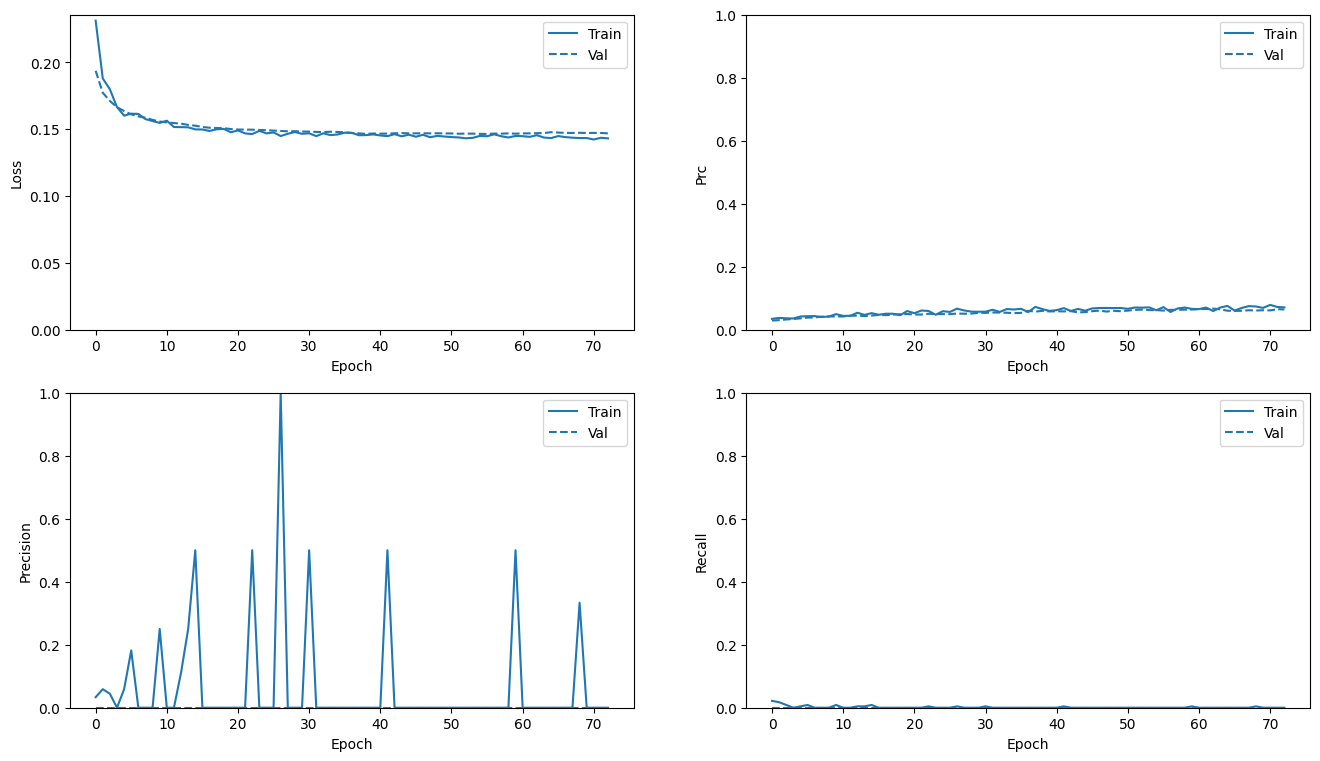

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model44.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model44.predict(X_test, batch_size=BATCH_SIZE)

3/3 [==============================] - 0s 3ms/step


In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.1336164027452469
cross entropy :  0.1336164027452469
Brier score :  0.030973874032497406
tp :  0.0
fp :  0.0
tn :  323.0
fn :  11.0
accuracy :  0.9670658707618713
precision :  0.0
recall :  0.0
auc :  0.7640022039413452
prc :  0.17447063326835632

Legitimate Transactions Detected (True Negatives):  323
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  11


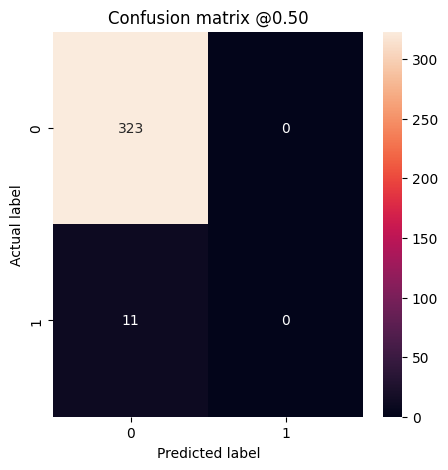

In [ ]:
baseline_results = model44.evaluate(X_test, y_test,
                                    batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model44.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  290
Legitimate Transactions Incorrectly Detected (False Positives):  33
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  3
Total Fraudulent Transactions:  11
Legitimate Transactions Detected (True Negatives):  6
Legitimate Transactions Incorrectly Detected (False Positives):  317
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  11
Total Fraudulent Transactions:  11


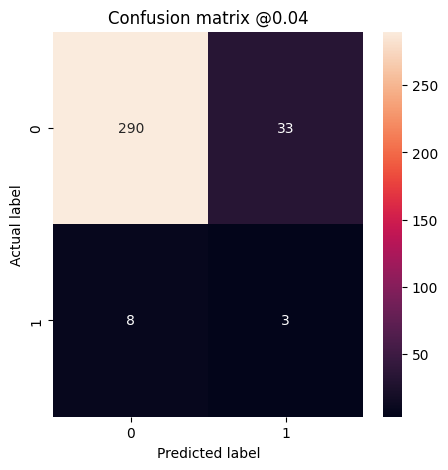

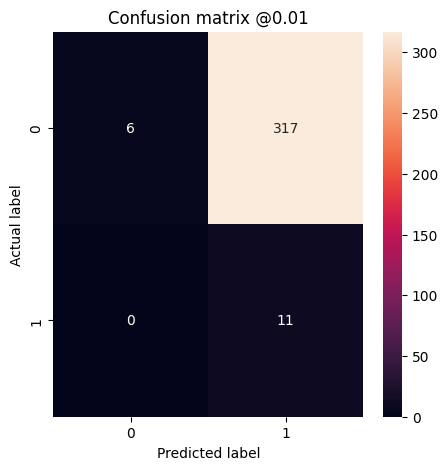

In [ ]:
plot_cm(y_test, test_predictions_baseline, threshold=0.045)
plot_cm(y_test, test_predictions_baseline, threshold=0.01)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

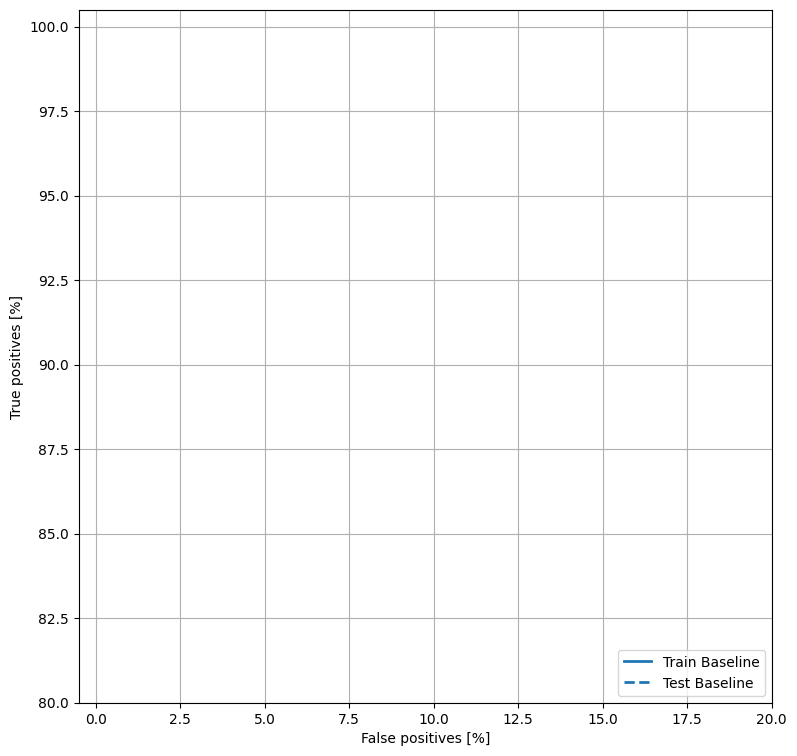

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

# SMOTE

**Synthetic Minority Oversampling Technique** - SMOTE identifies a set of the neighbors for each sample in the imbalanced class; new samples generated by interpolation between it and its neighbors; generated samples are combined with original dataset.

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=seed)
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       323
         1.0       0.08      0.09      0.09        11

    accuracy                           0.94       334
   macro avg       0.53      0.53      0.53       334
weighted avg       0.94      0.94      0.94       334



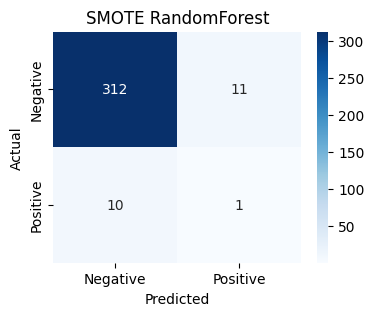

In [ ]:
generate_confusion_matrix(clf, X_test, y_test, title='SMOTE RandomForest')

In [ ]:
clf_balanced = BalancedRandomForestClassifier(n_estimators=100, random_state=seed)
clf_balanced.fit(X_train_res, y_train_res)

BalancedRandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf_balanced.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       323
         1.0       0.08      0.09      0.09        11

    accuracy                           0.94       334
   macro avg       0.53      0.53      0.53       334
weighted avg       0.94      0.94      0.94       334



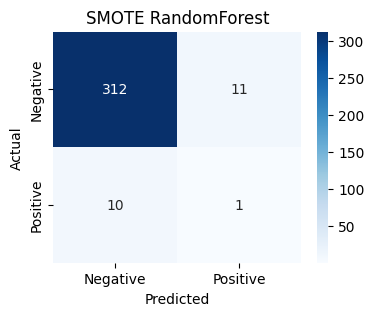

In [ ]:
generate_confusion_matrix(clf_balanced, X_test, y_test, title='SMOTE RandomForest')

## SMOTE with Boruta Feature Selection

In [ ]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=seed)
boruta_selector = BorutaPy(brf, n_estimators='auto', random_state=seed)

boruta_selector.fit(X_train_res, y_train_res)

BorutaPy(estimator=BalancedRandomForestClassifier(n_estimators=54,
                                                  random_state=RandomState(MT19937) at 0x7B4BD3BB3940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B4BD3BB3940)

In [ ]:
print("\n------Support and Ranking for each feature------")
for i in range(len(boruta_selector.support_)):
    if boruta_selector.support_[i]:
        print("Passes the test:\t", X_cols[i], ' ' * (20 - len(X_cols[i])),
              "\t- Ranking: ", boruta_selector.ranking_[i])
    else:
        print("Doesn't pass the test:\t",
              X_cols[i], ' ' * (20 - len(X_cols[i])), "\t- Ranking: ", boruta_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:	 stories_above_ground  	- Ranking:  1
Passes the test:	 stories_below_ground  	- Ranking:  1
Doesn't pass the test:	 steel_frame           	- Ranking:  2
Doesn't pass the test:	 reinforced_concrete   	- Ranking:  4
Doesn't pass the test:	 lightweight           	- Ranking:  5
Doesn't pass the test:	 block                 	- Ranking:  11
Doesn't pass the test:	 wood                  	- Ranking:  3
Doesn't pass the test:	 rice_paddy            	- Ranking:  7
Passes the test:	 other_agriculture     	- Ranking:  1
Passes the test:	 forest                	- Ranking:  1
Doesn't pass the test:	 wasteland             	- Ranking:  9
Passes the test:	 building              	- Ranking:  1
Passes the test:	 road_transport        	- Ranking:  1
Passes the test:	 rail_transport        	- Ranking:  1
Passes the test:	 other_site            	- Ranking:  1
Passes the test:	 river_wetland         	- Ranking:  1
Doesn't pass the test:	 sea

In [ ]:
selected_features = boruta_selector.support_
X_train_res_selected = X_train_res[:, selected_features]
X_test_selected = X_test[:, selected_features]
X_train_res_selected.shape, X_test_selected.shape

((12890, 15), (334, 15))

In [ ]:
clf_selected = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
clf_selected.fit(X_train_res_selected, y_train_res)

BalancedRandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf_selected.predict(X_test_selected)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       323
         1.0       0.07      0.09      0.08        11

    accuracy                           0.93       334
   macro avg       0.52      0.53      0.52       334
weighted avg       0.94      0.93      0.94       334



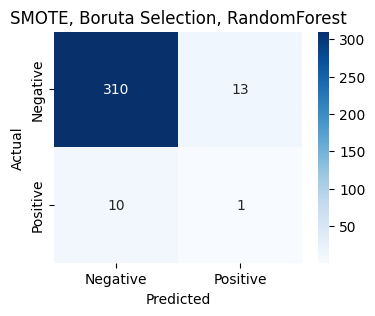

In [ ]:
generate_confusion_matrix(clf_selected, X_test_selected, y_test, title='SMOTE, Boruta Selection, RandomForest')

## Grid search with cross-validation

In [ ]:
brf = BalancedRandomForestClassifier(random_state=seed)

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000]
}

grid_search = GridSearchCV(estimator=brf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

grid_search.fit(X_train_res_selected, y_train_res)

KeyboardInterrupt: 

In [ ]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_selected)

print(classification_report(y_test, y_pred))
generate_confusion_matrix(best_model, X_test_selected, y_test, title='SMOTE, Boruta Selection, Grid search RandomForest')

### Grid search for XGBoost

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.25],
    'subsample': [0.4, 0.6, 0.8, 1.0]
}

# Initialize the model
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialize Grid Search CV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit Grid Search CV
grid_search.fit(X_train_res_selected, y_train_res)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model score
print("Best Cross-Validation Score:", grid_search.best_score_)

# Test set performance
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_selected, y_test)
print("Test Set Score:", test_score)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400, 'subsample': 1.0}
Best Cross-Validation Score: 0.9695112490302561
Test Set Score: 0.9341317365269461


              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       323
         1.0       0.08      0.09      0.08        11

    accuracy                           0.93       334
   macro avg       0.52      0.53      0.52       334
weighted avg       0.94      0.93      0.94       334



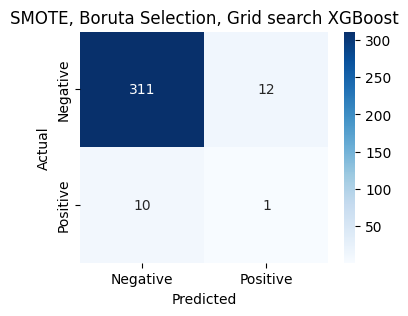

In [ ]:
y_pred = best_model.predict(X_test_selected)

print(classification_report(y_test, y_pred))
generate_confusion_matrix(best_model, X_test_selected, y_test, title='SMOTE, Boruta Selection, Grid search XGBoost')

# Attempt #2

## XGBoost

In [14]:
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Step 2: Apply PCA for decorrelation
pca = PCA(n_components=min(len(X_scaled), len(X_scaled[0])))  # Ensure n_components is valid
X_pca = pca.fit_transform(X_scaled)

In [16]:
# Step 3: Address class imbalance using SMOTE
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

In [17]:
# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled)

In [ ]:
# Step 5: Apply Boruta for feature selection
forest = xgb.XGBClassifier(random_state=42)
boruta = BorutaPy(estimator=forest, n_estimators='auto', random_state=42)
boruta.fit(X_train, y_train)

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=72,
                                 n_jobs=None, num_parallel_tree=None,
                                 random_state=579240164, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x786AF60CB540)

In [ ]:
len(boruta.ranking_)

26

In [ ]:
# Select the features
X_train_selected = boruta.transform(X_train)
X_test_selected = boruta.transform(X_test)

In [ ]:
# Step 6: Define the model
model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
                          objective='binary:logistic',
                          eval_metric='logloss',
                          use_label_encoder=False,
                          random_state=seed)

In [ ]:
# Step 7: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# Step 8: Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

In [ ]:
# Step 9: Predict and evaluate
y_pred = grid_search.best_estimator_.predict(X_test_selected)

In [ ]:
# Step 10: Print the recall score and classification report
print("Best Parameters:", grid_search.best_params_)
print("Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Recall: 0.9608938547486033
              precision    recall  f1-score   support

     Class 0       0.96      0.89      0.92      1612
     Class 1       0.90      0.96      0.93      1611

    accuracy                           0.93      3223
   macro avg       0.93      0.93      0.93      3223
weighted avg       0.93      0.93      0.93      3223



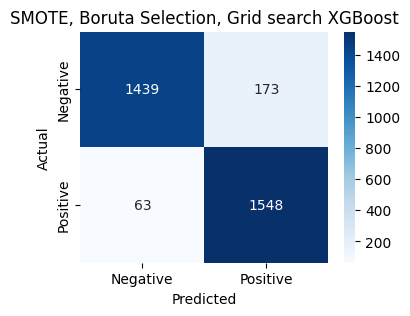

In [ ]:
generate_confusion_matrix(grid_search.best_estimator_,
                          X_test_selected,
                          y_test,
                          title='SMOTE, Boruta Selection, Grid search XGBoost')

## Balanced Random Forest

In [18]:
# Step 5: Apply Boruta for feature selection
forest_br = BalancedRandomForestClassifier(random_state=seed)
boruta_br = BorutaPy(estimator=forest_br, n_estimators='auto', random_state=seed)
boruta_br.fit(X_train, y_train)

# Select the features
X_train_selected_br = boruta_br.transform(X_train)
X_test_selected_br = boruta_br.transform(X_test)

# Step 6: Define the model
model_br = BalancedRandomForestClassifier(random_state=seed)

# Step 7: Define the parameter grid for hyperparameter tuning
param_grid_br = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# Step 8: Perform Grid Search with cross-validation
grid_search_br = GridSearchCV(estimator=model_br, param_grid=param_grid_br, scoring='recall', cv=5, n_jobs=-1)
grid_search_br.fit(X_train_selected_br, y_train)

# Step 9: Predict and evaluate
y_pred_br = grid_search_br.best_estimator_.predict(X_test_selected_br)

# Step 10: Print the recall score and classification report
print("Best Parameters:", grid_search_br.best_params_)
print("Recall:", recall_score(y_test, y_pred_br))
print(classification_report(y_test, y_pred_br, target_names=['Class 0', 'Class 1']))

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Recall: 0.9584109248913718
              precision    recall  f1-score   support

     Class 0       0.96      0.95      0.95      1612
     Class 1       0.95      0.96      0.95      1611

    accuracy                           0.95      3223
   macro avg       0.95      0.95      0.95      3223
weighted avg       0.95      0.95      0.95      3223



In [19]:
dump(grid_search_br.best_estimator_, 'models/tokyo_brf.joblib')
dump(scaler, 'models/tokyo_brf_scaler.joblib')
dump(pca, 'models/tokyo_brf_pca.joblib')

['models/tokyo_brf_pca.joblib']

In [21]:
dump(boruta_br, 'models/tokyo_brf_boruta.joblib')

['models/tokyo_brf_boruta.joblib']

In [ ]:
boruta_br.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False])

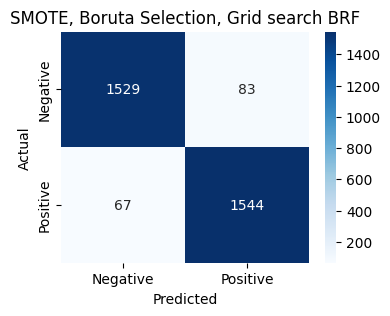

In [ ]:
generate_confusion_matrix(grid_search_br.best_estimator_,
                          X_test_selected_br,
                          y_test,
                          title='SMOTE, Boruta Selection, Grid search BRF')

## Preprocessing Superfunction

In [ ]:
np.float = np.float32
np.int = np.int32
np.bool = np.bool_

In [ ]:
def preprocess_data(X, y, test_size=0.2, random_state=seed, boruta=None, split=True):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(len(X_scaled), len(X_scaled[0])))  # Ensure n_components is valid
    X_pca = pca.fit_transform(X_scaled)

    # Address class imbalance using SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_pca, y)

    # Apply Boruta for feature selection if provided
    if boruta is not None:
        boruta.fit(X_resampled, y_resampled)
        X_selected = boruta.transform(X_resampled)
    else:
        X_selected = X_resampled

    if split:
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=test_size, random_state=random_state, stratify=y_resampled)

        return X_train, X_test, y_train, y_test

    else:
        return X_selected, y_resampled

In [31]:
def preprocess_test_data(X, scaler, pca, boruta):
    scaled_test_data = scaler.transform(X)
    pca_test_data = pca.transform(scaled_test_data)
    return boruta.transform(pca_test_data)

In [ ]:
tokyo_brf = load('models/tokyo_brf.joblib')

# Ibaraki Test Data

In [ ]:
X_ibaraki = np.load('data/arrays/ibaraki_more/x.npy', allow_pickle=True).astype(np.float32)
y_ibaraki = np.load('data/arrays/ibaraki_more/y.npy', allow_pickle=True).astype(np.float32)
X_ibaraki.shape, y_ibaraki.shape

((733, 26), (733, 1))

In [ ]:
data_ibaraki = pd.DataFrame(X_ibaraki, columns=[f'Feature_{i+1}' for i in range(X_ibaraki.shape[1])])
data_ibaraki['Label'] = y_ibaraki

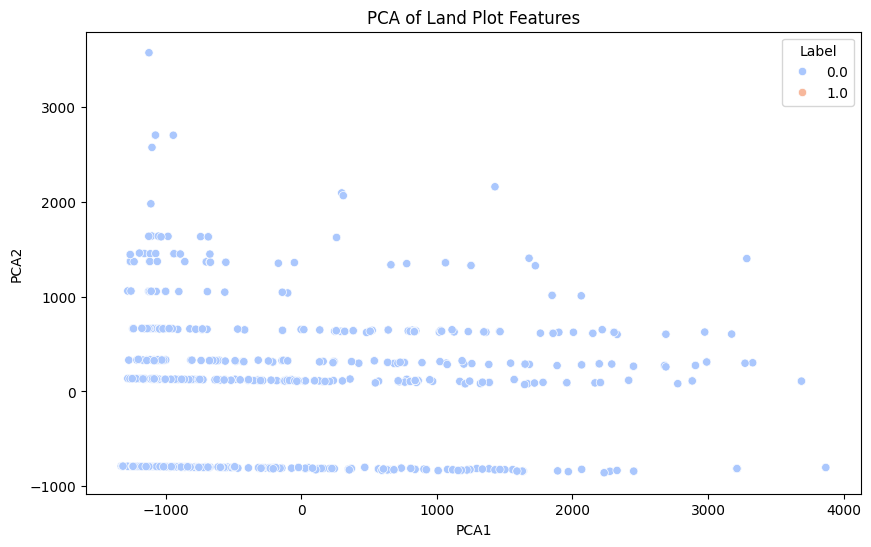

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_ibaraki)
data_ibaraki['PCA1'] = pca_result[:, 0]
data_ibaraki['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=data_ibaraki, palette='coolwarm')
plt.title('PCA of Land Plot Features')
plt.show()

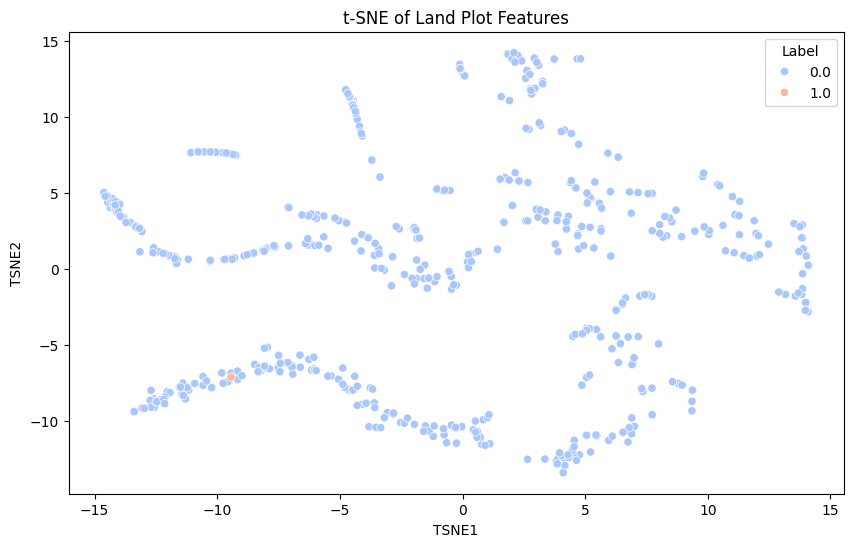

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(X_ibaraki)
data_ibaraki['TSNE1'] = tsne_result[:, 0]
data_ibaraki['TSNE2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=data_ibaraki, palette='coolwarm')
plt.title('t-SNE of Land Plot Features')
plt.show()

BalancedRandomForest
- SMOTE
- Boruta Selection
- Grid Search, `n_estimators`=100

In [ ]:
X_ibaraki_processed, y_ibaraki_processed = preprocess_data(X_ibaraki, y_ibaraki, split=False, boruta=None)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

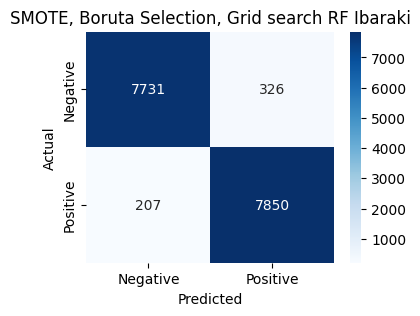

In [ ]:
generate_confusion_matrix(grid_search_br.best_estimator_,
                          X_ibrakai_processed,
                          y_ibrakai_processed,
                          title='SMOTE, Boruta Selection, Grid search RF Ibaraki')

# Chiba Test Data

In [20]:
X_chiba = np.load('data/arrays/chiba_more/x.npy', allow_pickle=True).astype(np.float32)
y_chiba = np.load('data/arrays/chiba_more/y.npy', allow_pickle=True).astype(np.float32)
X_chiba.shape, y_chiba.shape

((3632, 26), (3632, 1))

In [ ]:
data_chiba = pd.DataFrame(X_chiba, columns=[f'Feature_{i+1}' for i in range(X_chiba.shape[1])])
data_chiba['Label'] = y_chiba

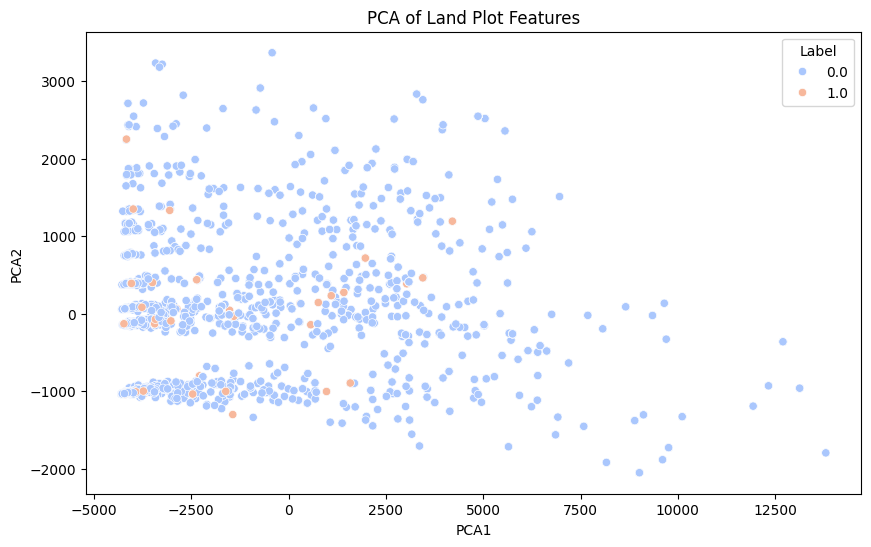

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_chiba)
data_chiba['PCA1'] = pca_result[:, 0]
data_chiba['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=data_chiba, palette='coolwarm')
plt.title('PCA of Land Plot Features')
plt.show()

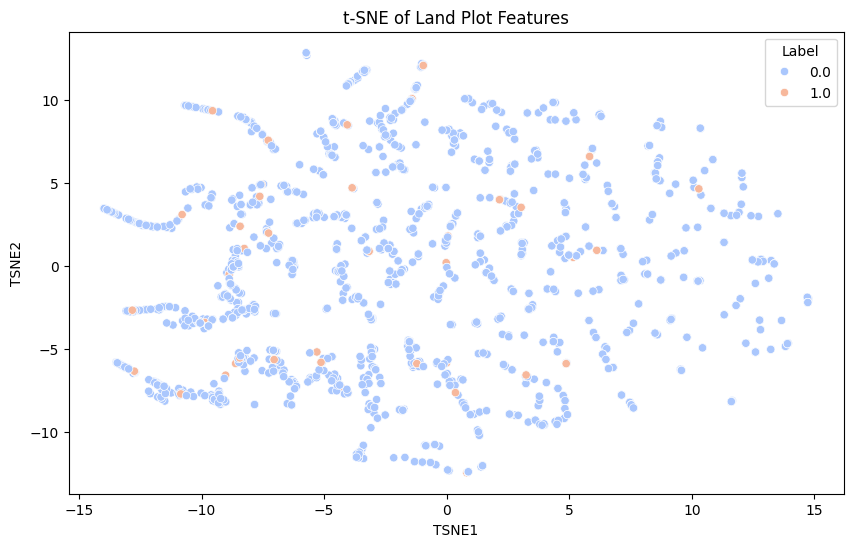

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(X_chiba)
data_chiba['TSNE1'] = tsne_result[:, 0]
data_chiba['TSNE2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=data_chiba, palette='coolwarm')
plt.title('t-SNE of Land Plot Features')
plt.show()

In [32]:
X_chiba_processed = preprocess_test_data(X_chiba, scaler, pca, boruta_br)

BalancedRandomForest
- SMOTE
- Boruta Selection
- Grid Search, `n_estimators`=100

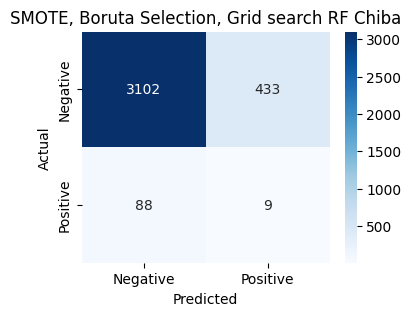

In [27]:
generate_confusion_matrix(grid_search_br.best_estimator_, # grid_search_br.best_estimator_
                          X_chiba_processed,
                          y_chiba,
                          title='SMOTE, Boruta Selection, Grid search RF Chiba')